Medical Cost Personal Datasets

Kaggle Link: https://www.kaggle.com/datasets/mirichoi0218/insurance

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import cut_the_tails as ct
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [2]:
df = pd.read_csv('data_sets\\medical_costs.csv')
target = 'charges'

In [3]:
features = [
 'age',
 'sex',
 'bmi',
 'children',
 'smoker',
 'region'
 ]

In [4]:
fig = px.histogram(df, x=target, nbins=100)
fig.show()

# Pré-Processamento

In [5]:
#the columns that have nominal attributes
nominal_atts = ['sex', 'smoker', 'region']

#using the one hot encoder
one = OneHotEncoder()

transformer = make_column_transformer((OneHotEncoder(sparse_output=False), nominal_atts), remainder='passthrough')

transformed = transformer.fit_transform(df)

transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

# Updating the features list
features = transformer.get_feature_names_out().tolist()
target = 'remainder__charges'
features.remove(target)

transformed_df.head()


,onehotencoder__sex_female,onehotencoder__sex_male,onehotencoder__smoker_no,onehotencoder__smoker_yes,onehotencoder__region_northeast,onehotencoder__region_northwest,onehotencoder__region_southeast,onehotencoder__region_southwest,remainder__age,remainder__bmi,remainder__children,remainder__charges
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,19.0,27.900,0.0,16884.92400
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,18.0,33.770,1.0,1725.55230
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,28.0,33.000,3.0,4449.46200
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,33.0,22.705,0.0,21984.47061
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,32.0,28.880,0.0,3866.85520


# Cauda Ótima

[0.0, 0.1]


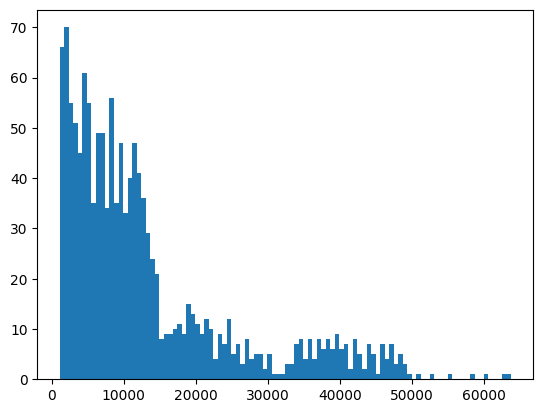

In [12]:
df.dropna(inplace=True)
df = df.reset_index(drop=True)

model = DecisionTreeRegressor(random_state=0, max_depth=5) 
classifier = DecisionTreeClassifier(random_state=0, max_depth=5)

optimal = ct.get_optimal_percentiles(transformed_df, target, features, classifier, model, 'normal', 'brute-force', 1)

print(optimal)

In [175]:
cdf = ct.split_by_quantile_class(transformed_df,target,[0.0,0.45])

cdf.dropna(inplace=True)

In [176]:
X = cdf[features].to_numpy()
y_tail = cdf['tail_class'].to_numpy()
y = cdf[target].to_numpy()

###Using split###
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#X_train_aux, X_test_aux, y_train_tail, y_test_tail = train_test_split(X, y_tail, test_size=0.2, random_state=0)

In [177]:
#baseline = RandomForestRegressor(max_depth=5, random_state=0)
baseline = XGBRegressor(n_estimators=100, max_leaves=0, random_state = 0)
#baseline = DecisionTreeRegressor(random_state=0, max_depth=5) 

In [178]:
#tail_classifier = ct.fit_tail_classifier(X,y_tail,RandomForestClassifier(max_depth=5, random_state=0))
tail_classifier = ct.fit_tail_classifier(X,y_tail,XGBClassifier(n_estimators=100, max_leaves=0, random_state = 0))
#tail_classifier = ct.fit_tail_classifier(X,y_tail,DecisionTreeClassifier(random_state=0, max_depth=5)) 

###Using split###
#tail_classifier = ct.fit_tail_classifier(X_train,y_train_tail,RandomForestClassifier(max_depth=5, random_state=0))
#tail_classifier = ct.fit_tail_classifier(X_train,y_train_tail,XGBClassifier(n_estimators=100, max_leaves=0, random_state = 0))
#tail_classifier = ct.fit_tail_classifier(X_train,y_train_tail,DecisionTreeClassifier(random_state=0, max_depth=5)) 

In [179]:
models = ct.fit_tail_models(X,y,y_tail,baseline)

###Using split###
#models = ct.fit_tail_models(X_train,y_train,y_train_tail,baseline)

In [180]:
baseline.fit(X,y)
y_base = baseline.predict(X)
y_tail = ct.batch_tail_predict(X,tail_classifier,models)

###Using split###
#baseline.fit(X_train,y_train)
#y_base = baseline.predict(X_test)
#y_tail = ct.batch_tail_predict(X_test,tail_classifier,models)

In [181]:
print(mean_absolute_error(y_base,y))
print(mean_absolute_error(y_tail,y))
print(mean_absolute_error(y,y))

###Using split###
#print(mean_absolute_error(y_base,y_test))
#print(mean_absolute_error(y_tail,y_test))
#print(mean_absolute_error(y_test,y_test))

642.7766739479955
205.86771486390606
0.0


In [182]:
print(mean_absolute_percentage_error(y_base,y))
print(mean_absolute_percentage_error(y_tail,y))
print(mean_absolute_percentage_error(y,y))

###Using split###
#print(mean_absolute_percentage_error(y_base,y_test))
#print(mean_absolute_percentage_error(y_tail,y_test))
#print(mean_absolute_percentage_error(y_test,y_test))

0.08139621786035228
0.02425839000380814
0.0
